In [21]:
import os, json, re, math, string, unicodedata, collections, itertools, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from unidecode import unidecode

import nltk
from nltk.corpus import stopwords

import networkx as nx
import community as community_louvain  # paquete python-louvain

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Config general de plots
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["axes.grid"] = True

DATA_PATH = "data/traficogt.txt"   # <- AJUSTA si es necesario
SEED = 42
np.random.seed(SEED)

Carga del dataset

In [22]:
def read_jsonl_in_chunks(path, max_rows=None, chunk_size=10000):
    """
    Lee un JSONL pesado en bloques, devuelve DataFrame con columnas clave ya extraídas.
    max_rows: si quieres muestrear por desarrollo (e.g., 50_000); None = todo.
    """
    rows = []
    with open(path, "r", encoding="utf-16") as f: 
        for i, line in enumerate(f):
            if max_rows is not None and i >= max_rows:
                break
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue

            # Campos principales
            row = {
                "id": obj.get("id"),
                "date": obj.get("date"),
                "lang": obj.get("lang"),
                "rawContent": obj.get("rawContent") or "",
                "replyCount": obj.get("replyCount"),
                "retweetCount": obj.get("retweetCount"),
                "likeCount": obj.get("likeCount"),
                "quoteCount": obj.get("quoteCount"),
                "viewCount": obj.get("viewCount"),
                "sourceLabel": (obj.get("sourceLabel") or obj.get("source")),
            }

            # Usuario autor
            u = obj.get("user") or {}
            row.update({
                "user_id": u.get("id"),
                "username": (u.get("username") or "").lower(),
                "displayname": u.get("displayname") or "",
                "user_followers": u.get("followersCount"),
                "user_friends": u.get("friendsCount"),
            })

            # Menciones (lista de objetos con username/displayname) -> guardamos usernames (lower)
            mentioned = obj.get("mentionedUsers") or []
            row["mentions"] = [ (mu.get("username") or "").lower()
                                for mu in mentioned if mu and mu.get("username") ]

            # Hashtags si existieran (como no me puse a ver todo el JSON, asumo que es lista de strings)
            row["hashtags"] = [h.lower() for h in (obj.get("hashtags") or [])]

            # Retweet/Reply/Quote (heurísticas)
            row["is_retweet"] = obj.get("retweetedTweet") is not None
            row["is_quote"]   = obj.get("quotedTweet") is not None

            # Reply detectado por metadata si existe; si no, por texto que inicia con @
            row["is_reply"] = False
            if obj.get("inReplyToTweetId") or obj.get("inReplyToUser"):
                row["is_reply"] = True
            else:
                # fallback textual
                row["is_reply"] = bool(re.match(r"^\s*@\w+", row["rawContent"]))

            rows.append(row)

    df = pd.DataFrame(rows)
    if not df.empty:
        df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)
    return df

# TIP para desarrollo: usa max_rows para iterar rápido; luego quítalo para el corrida final.
df = read_jsonl_in_chunks(DATA_PATH, max_rows=None)
df.info()
df.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5604 entries, 0 to 5603
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              5604 non-null   int64              
 1   date            5604 non-null   datetime64[ns, UTC]
 2   lang            5604 non-null   object             
 3   rawContent      5604 non-null   object             
 4   replyCount      5604 non-null   int64              
 5   retweetCount    5604 non-null   int64              
 6   likeCount       5604 non-null   int64              
 7   quoteCount      5604 non-null   int64              
 8   viewCount       5600 non-null   float64            
 9   sourceLabel     5604 non-null   object             
 10  user_id         5604 non-null   int64              
 11  username        5604 non-null   object             
 12  displayname     5604 non-null   object             
 13  user_followers  5604 non-null   i

,id,date,lang,rawContent,replyCount,retweetCount,likeCount,quoteCount,viewCount,sourceLabel,user_id,username,displayname,user_followers,user_friends,mentions,hashtags,is_retweet,is_quote,is_reply
0,1834236045598056867,2024-09-12 14:22:06+00:00,es,Es comprensible la resolución... El ruso sabe ...,0,0,1,0,393.0,Twitter for Android,93938886,traficogt,traficoGT,314368,137,[],[],False,True,False
1,1834029142565658846,2024-09-12 00:39:56+00:00,es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,4,1587.0,Twitter for Android,976875408,monymmorales,Mony,5502,4887,[cc_guatemala],[],False,False,False
2,1834039491826180424,2024-09-12 01:21:04+00:00,qme,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,0,91.0,Twitter for iPhone,1730828822029750272,animaldgalaccia,Jairo De La Nada,571,158,"[pncdeguatemala, mingobguate, fjimenezmingob, ...",[],False,False,True


El archivo es JSON-Lines (una línea por tweet). Vamos a leer en chunks para no saturar memoria.

In [23]:
# Descarga stopwords la 1a vez:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

SPANISH_STOPWORDS = set(stopwords.words('spanish'))

URL_RE      = re.compile(r'https?://\S+|www\.\S+', flags=re.IGNORECASE)
MENTION_RE  = re.compile(r'@([A-Za-z0-9_]{1,15})')
HASHTAG_RE  = re.compile(r'#(\w+)')
EMOJI_RE    = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)

def normalize_username(u):
    if pd.isna(u): return ""
    return unidecode(str(u).strip().lower())

def clean_text(text: str):
    """Limpieza amigable para español (explicable en informe)."""
    if pd.isna(text): return ""
    t = str(text)
    t = URL_RE.sub(" ", t)
    t = EMOJI_RE.sub(" ", t)               # opcional: quitar emojis
    t = t.lower()
    t = unicodedata.normalize("NFKD", t)
    t = "".join(ch for ch in t if not unicodedata.combining(ch))
    t = t.translate(str.maketrans("", "", string.punctuation))
    t = re.sub(r"\d+", " ", t)             # quitar números
    tokens = re.findall(r"\b\w+\b", t)
    tokens = [w for w in tokens if w not in SPANISH_STOPWORDS and len(w) > 2]
    return " ".join(tokens)

def extract_mentions_from_text(text):
    """Extrae @handles del texto (además de los que ya vienen en 'mentions')."""
    return [m.lower() for m in MENTION_RE.findall(text or "")]

def extract_hashtags_from_text(text):
    return [h.lower() for h in HASHTAG_RE.findall(text or "")]

# Normalizaciones y campos limpios
df["username"]  = df["username"].map(normalize_username)
df["text_clean"] = df["rawContent"].map(clean_text)

# Unificar menciones: las que vienen en metadata + las del texto
extra_m = df["rawContent"].map(extract_mentions_from_text)
df["mentions_all"] = [
    sorted(set((m or []) + (e or [])))
    for m, e in zip(df["mentions"], extra_m)
]

# Unificar hashtags
extra_h = df["rawContent"].map(extract_hashtags_from_text)
df["hashtags_all"] = [
    sorted(set((h or []) + (eh or [])))
    for h, eh in zip(df["hashtags"], extra_h)
]

# Eliminar duplicados (mismo usuario + texto + fecha)
before = len(df)
df = df.drop_duplicates(subset=["username","rawContent","date"]).reset_index(drop=True)
after = len(df)
print(f"Duplicados removidos: {before - after}")

# Chequeo rápido
df[["username","date","rawContent","text_clean","mentions_all","hashtags_all","is_retweet","is_reply","is_quote"]].head(5)


Duplicados removidos: 8


,username,date,rawContent,text_clean,mentions_all,hashtags_all,is_retweet,is_reply,is_quote
0,traficogt,2024-09-12 14:22:06+00:00,Es comprensible la resolución... El ruso sabe ...,comprensible resolucion ruso sabe engrasar maq...,[],[],False,False,True
1,monymmorales,2024-09-12 00:39:56+00:00,La corrupción de la @CC_Guatemala\nes descarad...,corrupcion ccguatemala descarada falsificacion...,[cc_guatemala],[],False,False,False
2,animaldgalaccia,2024-09-12 01:21:04+00:00,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,pncdeguatemala mingobguate fjimenezmingob dieg...,"[amilcarmontejo, diegoedeleon, fjimenezmingob,...",[],False,True,False
3,estaciondoblea,2024-09-11 20:20:01+00:00,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,amilcarmontejo aztecanoticiagt bancadasemilla ...,"[amilcarmontejo, aztecanoticiagt, bancadasemil...",[],False,True,False
4,cubreserva,2024-09-11 00:34:31+00:00,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,aztecanoticiagt conapgt denunciaempagua munigu...,"[aztecanoticiagt, conapgt, denunciaempagua, em...",[],False,True,False


Quitar minúsculas, quitar urls, puntuación, números, emojis, stopwords; normalizar usernames y menciones; eliminar duplicados; extraer interacciones.

### EDA: conteos, top hashtags/mentions, nube de palabras y actividad temporal

In [24]:
num_tweets      = len(df)
num_usuarios    = df["username"].nunique()
num_menciones   = sum(len(x) for x in df["mentions_all"])
all_mentions    = list(itertools.chain.from_iterable(df["mentions_all"]))
all_hashtags    = list(itertools.chain.from_iterable(df["hashtags_all"]))

print("Tweets:", num_tweets)
print("Usuarios únicos:", num_usuarios)
print("Total menciones:", num_menciones)
print("Total hashtags:", len(all_hashtags))

top_mentions = Counter(all_mentions).most_common(15)
top_hashtags = Counter(all_hashtags).most_common(15)
pd.DataFrame(top_mentions, columns=["mention","freq"]).head(10)


Tweets: 5596
Usuarios únicos: 2071
Total menciones: 10953
Total hashtags: 590


,mention,freq
0,traficogt,4232
1,barevalodeleon,426
2,drgiammattei,172
3,amilcarmontejo,165
4,prensacomunitar,162
5,mpguatemala,139
6,mmendoza_gt,131
7,lahoragt,128
8,cc_guatemala,109
9,muniguate,96


In [25]:
pd.DataFrame(top_hashtags, columns=["hashtag","freq"]).head(10)

,hashtag,freq
0,ahora,30
1,guatemala,25
2,ahoralh,19
3,urgente,16
4,traficogt,16
5,renunciengolpistas,15
6,lahoradeactualizarnos,8
7,guateresiste,8
8,paronacionalindefinido,8
9,paronacionaindefinido,8


La conversación gira alrededor de @traficoGT (mención dominante), con fuerte presencia de instituciones/autoridades (PNC, MP, Muni, CC, prensa) → se usan como fuentes y receptores de reportes/quejas.

Aparecen temas políticos (p. ej., #renunciengolpistas, barevalodeleon, drgiammattei), lo que sugiere que el timelinea de @traficoGT también captura coyuntura (protestas/paro), no solo tráfico.

Implicación P1: al analizar atascos/horarios, debemos filtrar o anotar este sesgo temático porque puede inflar actividad en horas de noticias.

Insight accionable: separar tweets operativos de tráfico (palabras clave: accidente, anillo, calzada, periférico, lluvia, PMT, cola, choque) de los políticos para un análisis más fino de congestión.
(Alineado con el punto 4 de la guía: EDA + preguntas/insights.)

### 4.1 Nube de palabras del texto limpio

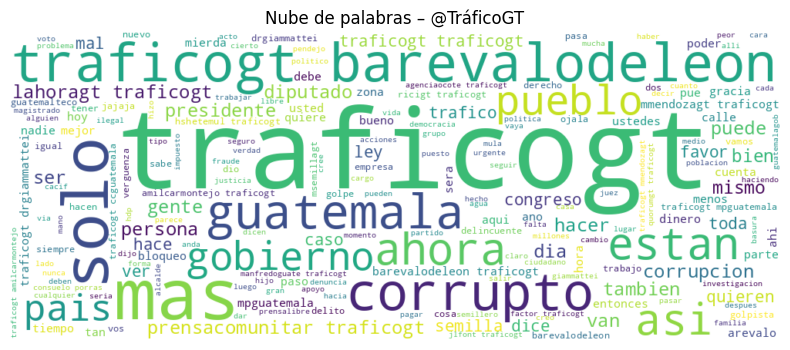

In [26]:
text_for_wc = " ".join(df["text_clean"].tolist())
if text_for_wc.strip():
    wc = WordCloud(width=1000, height=400, background_color="white").generate(text_for_wc)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Nube de palabras – @TráficoGT")
    plt.show()

Coexisten términos de actualidad política con léxico operativo de reporte. Esto confirma la dualidad temática del conjunto.

Para P1 (tráfico y lluvia), conviene cuantificar ocurrencias de palabras clave de clima/infraestructura (e.g., lluvia, aguacero, inundación, baches, derrumbe, semáforo, choque).

Insight: crear un diccionario temático (tráfico/clima) y contrastar su frecuencia por hora y por temporada de lluvias

### Actividad por hora local (conversión a hora de Guatemala UTC-6)

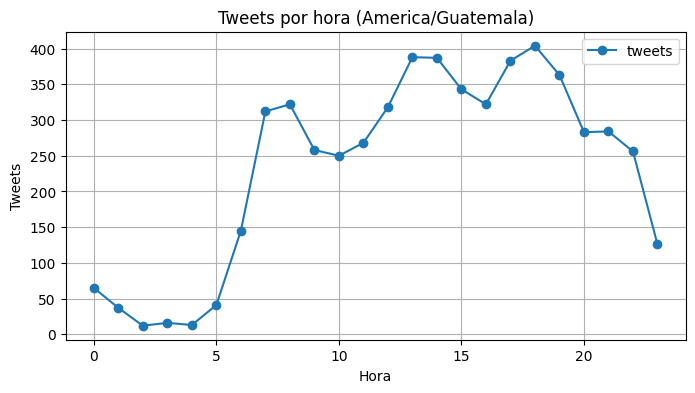

,hour,tweets
0,0,65
1,1,37
2,2,12
3,3,16
4,4,13


In [27]:
df_time = df.dropna(subset=["date"]).copy()
df_time["date_gt"] = df_time["date"].dt.tz_convert("America/Guatemala")
activity_hour = (
    df_time.assign(hour=lambda d: d["date_gt"].dt.hour)
           .groupby("hour")["id"].count()
           .reset_index(name="tweets")
           .sort_values("hour")
)
activity_hour.plot(x="hour", y="tweets", kind="line", marker="o", title="Tweets por hora (America/Guatemala)")
plt.xlabel("Hora"); plt.ylabel("Tweets"); plt.show()
activity_hour.head()

Hay dos ventanas claras de alta actividad: mañana laboral (8–11 h) y tarde–noche (16–19 h), consistentes con horarios pico de movilidad.

El máximo alrededor de 18–19 h sugiere congestión vespertina y/o mayor consumo/producción de noticias.

### Construcción de red dirigida (usuarios como nodos; interacciones como aristas)

In [28]:
def guess_primary_target_for_retweet_or_reply(row):
    """
    Heurística: si es RT/Reply/Quote y hay al menos una mención, usamos la 1a como objetivo.
    Si no hay mención explícita, podemos dejar sin arista específica para ese tipo.
    """
    ms = row["mentions_all"] or []
    return ms[0] if ms else None

rows = []
for _, r in df.iterrows():
    src = r["username"]
    if not src: 
        continue

    # Mentions (todas)
    for m in r["mentions_all"]:
        if m and m != src:
            rows.append((src, m, "mention"))

    # Reply
    if r["is_reply"]:
        tgt = guess_primary_target_for_retweet_or_reply(r)
        if tgt and tgt != src:
            rows.append((src, tgt, "reply"))

    # Retweet
    if r["is_retweet"] or r["is_quote"]:
        tgt = guess_primary_target_for_retweet_or_reply(r)
        if tgt and tgt != src:
            rows.append((src, tgt, "retweet" if r["is_retweet"] else "quote"))

edges = pd.DataFrame(rows, columns=["source","target","type"]).drop_duplicates()
edges = edges[edges["source"].notna() & edges["target"].notna() & (edges["source"] != edges["target"])]
edges.head(5), edges["type"].value_counts()


(            source          target     type
 0     monymmorales    cc_guatemala  mention
 1  animaldgalaccia  amilcarmontejo  mention
 2  animaldgalaccia    diegoedeleon  mention
 3  animaldgalaccia  fjimenezmingob  mention
 4  animaldgalaccia     mingobguate  mention,
 type
 mention    7416
 reply      3383
 quote        63
 Name: count, dtype: int64)

La interacción está dominada por menciones (≈68%), luego respuestas (≈31%) y citas marginales.

Semántica elegida (actor → objetivo) modela bien reportes a autoridades/medios; las menciones capturan flujo de información “hacia” instituciones.

### Topología de la red: métricas + visualización

In [29]:
# Grafo dirigido
G = nx.from_pandas_edgelist(edges, source="source", target="target", edge_attr=["type"], create_using=nx.DiGraph())
print("Nodos:", G.number_of_nodes(), "Aristas:", G.number_of_edges())

# Densidad
density = nx.density(G)
print("Densidad:", density)

# Diámetro: sobre el componente débilmente conectado más grande (en no dirigido)
if G.number_of_nodes() > 0:
    GCC_nodes = max(nx.weakly_connected_components(G), key=len)
    Gcc = G.subgraph(GCC_nodes).to_undirected()
    try:
        diameter = nx.diameter(Gcc)
    except nx.NetworkXError:
        diameter = np.nan
else:
    diameter = np.nan
print("Diámetro (componente mayor):", diameter)

# Clustering promedio (en no dirigido)
clustering = nx.average_clustering(G.to_undirected()) if G.number_of_nodes() > 0 else np.nan
print("Coef. de agrupamiento (avg):", clustering)

Nodos: 2765 Aristas: 7416
Densidad: 0.0009703681798792535
Diámetro (componente mayor): 7
Coef. de agrupamiento (avg): 0.23006706116977305


Red muy dispersa (densidad ≈0.001): típico en RRSS; la mayoría no interactúa entre sí directamente.

Diámetro 7 (en la componente gigante): los dos usuarios más lejanos dentro del mayor grupo están a ≈7 saltos → la información puede viajar pero no es ultra-eficiente.

Clustering 0.23: existe formación de triángulos/grupos no triviales; probable presencia de subcomunidades alrededor de instituciones (PMT/PNC/medios) y microgrupos vecinales que se mencionan entre sí.

Implicación P1: una red con clustering moderado + hubs institucionales favorece que reportes de zonas críticas se concentren en ciertos actores (p. ej., @muniguate, @amilcarmontejo), lo que ayuda a identificar áreas recurrentes cuando crucemos con términos de ubicación/clima.

#### Visualización simple (spring)

Nodos backbone: 1191 Aristas backbone: 5147


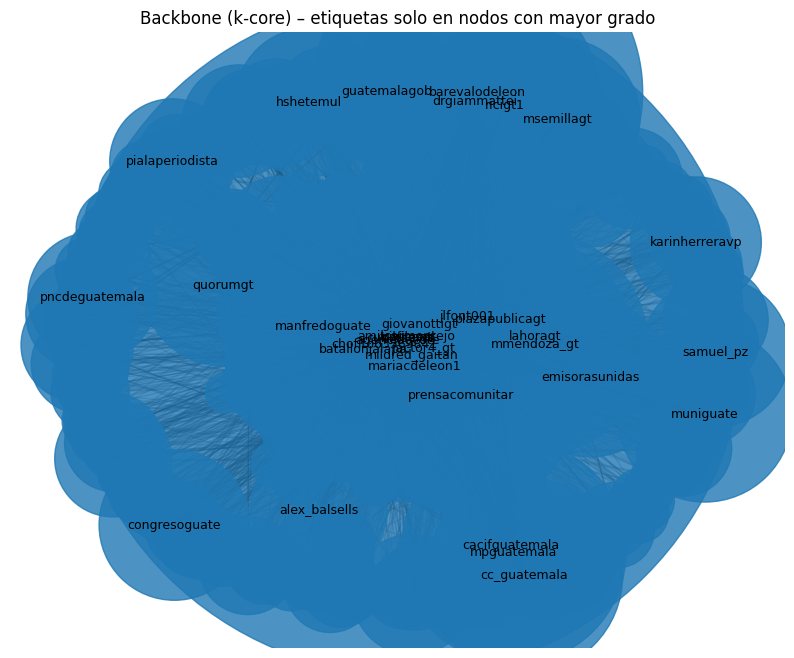

In [32]:
# 1) Tomamos la componente más grande
GCC_nodes = max(nx.weakly_connected_components(G), key=len)
Gcc = G.subgraph(GCC_nodes).copy()

# 2) Backbone por k-core (en no dirigido para el cálculo del core)
core_nodes = nx.k_core(Gcc.to_undirected(), k=3).nodes()  # prueba k=2,3,4
H = Gcc.subgraph(core_nodes).copy()
print("Nodos backbone:", H.number_of_nodes(), "Aristas backbone:", H.number_of_edges())

# 3) Layout spring estable
k = 1.2 / math.sqrt(max(H.number_of_nodes(), 1))  # distancia ideal
pos = nx.spring_layout(H, seed=42, k=k, iterations=200)

# 4) Tamaño por grado; labels solo para top-N
deg = dict(H.degree())
topN = 35
top_nodes = sorted(deg, key=deg.get, reverse=True)[:topN]
labels = {n: n for n in top_nodes}

plt.figure(figsize=(10,8))
nx.draw_networkx_nodes(H, pos, node_size=[60+260*deg[n] for n in H], alpha=0.8)
nx.draw_networkx_edges(H, pos, arrows=False, alpha=0.25)
nx.draw_networkx_labels(H, pos, labels=labels, font_size=9)
plt.title("Backbone (k-core) – etiquetas solo en nodos con mayor grado")
plt.axis("off"); plt.show()

6) Comunidades (Louvain) + visualizaciones